In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import itertools
import os
import random
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera, pearsonr,norm,stats,ks_2samp
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold, GridSearchCV, cross_val_predict, RepeatedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer,accuracy_score, precision_score, recall_score, classification_report, r2_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from scipy.linalg import orth
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from typing import Dict, Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

Data Processing

In [10]:
data = pd.read_csv('new Actual data.csv')
original_data = data.copy()
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              161 non-null    int64  
 1   station                 161 non-null    int64  
 2   sample number           161 non-null    object 
 3   longitude (° E)         161 non-null    float64
 4   latitude (°N)           161 non-null    float64
 5   Cr(mg/kg)               161 non-null    float64
 6   Cu(mg/kg)               161 non-null    float64
 7   Zn(mg/kg)               161 non-null    float64
 8   As(mg/kg)               161 non-null    float64
 9   Cd(mg/kg)               161 non-null    float64
 10  Pb(mg/kg)               161 non-null    float64
 11  Hg(mg/kg)               161 non-null    float64
 12  Ni(mg/kg)               161 non-null    float64
 13  Al2O3 (%)               161 non-null    float64
 14  clay (%)                161 non-null    fl

In [11]:
#Checking for missing values
data.isna().sum()

Unnamed: 0                0
station                   0
sample number             0
longitude (° E)           0
latitude (°N)             0
Cr(mg/kg)                 0
Cu(mg/kg)                 0
Zn(mg/kg)                 0
As(mg/kg)                 0
Cd(mg/kg)                 0
Pb(mg/kg)                 0
Hg(mg/kg)                 0
Ni(mg/kg)                 0
Al2O3 (%)                 0
clay (%)                  0
silt (%)                  0
sand (%)                  0
mean grain size(Mz, Φ)    0
water depth (m)           0
dtype: int64

Data Generation

Conditional Tabular Generative Adversarial Network(CTGAN)

In [12]:
# Handle compositional data (clay, silt, sand) with ILR transformation
def ilr_transform(data, comp_columns=['clay (%)', 'silt (%)', 'sand (%)']):
    # Replace zeros with small value to avoid log(0)
    data[comp_columns] = data[comp_columns].replace(0, 1e-6)
    comp_data = data[comp_columns].values
    ilr_data = np.log(comp_data[:, :-1] / comp_data[:, -1][:, np.newaxis]) @ orth(np.eye(len(comp_columns) - 1))
    ilr_columns = [f'ilr_{i+1}' for i in range(len(comp_columns) - 1)]
    ilr_df = pd.DataFrame(ilr_data, columns=ilr_columns, index=data.index)
    return ilr_df

def inverse_ilr_transform(ilr_data, comp_columns=['clay (%)', 'silt (%)', 'sand (%)']):
    # Inverse ILR transformation to recover compositional data
    ilr_data = ilr_data.values
    n_comps = len(comp_columns)
    ilr_mat = orth(np.eye(n_comps - 1))
    exp_data = np.exp(ilr_data @ ilr_mat.T)
    comp_data = exp_data / (1 + exp_data.sum(axis=1))[:, np.newaxis]
    comp_data = np.hstack((comp_data, 1 - comp_data.sum(axis=1)[:, np.newaxis]))
    # Ensure sum to 100%
    comp_data = comp_data / comp_data.sum(axis=1)[:, np.newaxis] * 100
    return pd.DataFrame(comp_data, columns=comp_columns)

# Apply ILR transformation to compositional columns
ilr_df = ilr_transform(data)
data = pd.concat([data.drop(columns=['clay (%)', 'silt (%)', 'sand (%)']), ilr_df], axis=1)

# Update numerical columns list to include ILR columns
numerical_columns = [col for col in data.columns if col not in ['clay (%)', 'silt (%)', 'sand (%)','station', 'sample number']] + ['ilr_1', 'ilr_2']

In [13]:
data_ctgan = data.copy()
# Normalize numerical columns
scaler = MinMaxScaler()
data_ctgan[numerical_columns] = scaler.fit_transform(data_ctgan[numerical_columns])

# Drop identifier columns for CTGAN training
data_for_ctgan = data_ctgan.drop(columns=['station', 'sample number'])

# Create metadata for CTGANSynthesizer
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data_for_ctgan)
# Ensure all columns are treated as numerical
for column in data_for_ctgan.columns:
    metadata.update_column(column_name=column, sdtype='numerical')
# Initialize and train CTGAN
model = CTGANSynthesizer(
    metadata=metadata,
    epochs=500,
    batch_size=100,
    verbose=True
)
model.fit(data_for_ctgan)

Gen. (-1.22) | Discrim. (-0.23): 100%|██████████| 500/500 [00:43<00:00, 11.37it/s]


GaussianCopulaSynthesizer

Training Gaussian Model

In [25]:
try:
    data = pd.read_csv('new Actual data.csv')
except FileNotFoundError:
    print("Error: 'new Actual data.csv' not found. Please ensure the file exists.")
    raise

# Define the expected column order from the original table
original_columns = [
    'station', 'sample number', 'longitude (° E)', 'latitude (°N)', 
    'Cr(mg/kg)', 'Cu(mg/kg)', 'Zn(mg/kg)', 'As(mg/kg)', 'Cd(mg/kg)', 
    'Pb(mg/kg)', 'Hg(mg/kg)', 'Ni(mg/kg)', 'Al2O3 (%)', 
    'clay (%)', 'silt (%)', 'sand (%)', 'mean grain size(Mz, Φ)', 'water depth (m)'
]



# Check for missing columns
missing_cols = [col for col in original_columns if col not in data.columns]
if missing_cols:
    print(f"Error: Missing columns in loaded data: {missing_cols}")
    print("Please verify the column names in your CSV file. They must match exactly:")
    print(original_columns)
    raise KeyError(f"Missing columns: {missing_cols}")

# ILR transformation functions
def ilr_transform(data, comp_columns=['clay (%)', 'silt (%)', 'sand (%)']):
    # Check if compositional columns exist
    missing_comp_cols = [col for col in comp_columns if col not in data.columns]
    if missing_comp_cols:
        print(f"Error: Compositional columns {missing_comp_cols} not found in DataFrame. Available columns: {list(data.columns)}")
        raise KeyError(f"Compositional columns {missing_comp_cols} not found")
    
    # Replace zeros with small value to avoid log(0)
    data[comp_columns] = data[comp_columns].replace(0, 1e-6)
    comp_data = data[comp_columns].values
    ilr_data = np.log(comp_data[:, :-1] / comp_data[:, -1][:, np.newaxis]) @ orth(np.eye(len(comp_columns) - 1))
    ilr_columns = [f'ilr_{i+1}' for i in range(len(comp_columns) - 1)]
    ilr_df = pd.DataFrame(ilr_data, columns=ilr_columns, index=data.index)
    return ilr_df

def inverse_ilr_transform(ilr_data, comp_columns=['clay (%)', 'silt (%)', 'sand (%)']):
    # Inverse ILR transformation to recover compositional data
    ilr_data = ilr_data.values
    n_comps = len(comp_columns)
    ilr_mat = orth(np.eye(n_comps - 1))
    exp_data = np.exp(ilr_data @ ilr_mat.T)
    comp_data = exp_data / (1 + exp_data.sum(axis=1))[:, np.newaxis]
    comp_data = np.hstack((comp_data, 1 - comp_data.sum(axis=1)[:, np.newaxis]))
    # Ensure sum to 100%
    comp_data = comp_data / comp_data.sum(axis=1)[:, np.newaxis] * 100
    return pd.DataFrame(comp_data, columns=comp_columns)
def prepare_data_for_gaussian_synthesis(original_data):
   
    data = original_data.copy()
    
    # Apply ILR transformation to compositional columns
    ilr_df = ilr_transform(data)
    data = pd.concat([data.drop(columns=['clay (%)', 'silt (%)', 'sand (%)']), ilr_df], axis=1)
    
    # Define numerical columns
    numerical_columns = [
        'longitude (° E)', 'latitude (°N)', 'Cr(mg/kg)', 'Cu(mg/kg)', 
        'Zn(mg/kg)', 'As(mg/kg)', 'Cd(mg/kg)', 'Pb(mg/kg)', 'Hg(mg/kg)', 
        'Ni(mg/kg)', 'Al2O3 (%)', 'mean grain size(Mz, Φ)', 'water depth (m)', 
        'ilr_1', 'ilr_2'
    ]
    
    # Filter to only existing columns
    existing_numerical_columns = [col for col in numerical_columns if col in data.columns]
    
    # Handle any missing values
    data = data.fillna(data.median(numeric_only=True))
    
    # Normalize numerical columns
    scaler = MinMaxScaler()
    data[existing_numerical_columns] = scaler.fit_transform(data[existing_numerical_columns])
    
    return data, scaler, existing_numerical_columns


def train_gaussian_model(data):
    # Remove identifier columns for training
    identifier_columns = ['station', 'sample number']
    data_for_training = data.copy()
    
    # Drop identifier columns if they exist
    for col in identifier_columns:
        if col in data_for_training.columns:
            data_for_training = data_for_training.drop(columns=[col])
    
    # Create metadata
    metadata = SingleTableMetadata()
    
    # Add all columns as numerical
    for column in data_for_training.columns:
        metadata.add_column(column_name=column, sdtype='numerical')
    
    # Initialize the synthesizer
    synthesizer = GaussianCopulaSynthesizer(
        metadata=metadata,
        numerical_distributions={
            'longitude (° E)': 'truncnorm',
            'latitude (°N)': 'truncnorm',
        }
    )
    
   
    
    # Fit the model
    synthesizer.fit(data_for_training)
    
    
    return synthesizer, data_for_training


Generation of data

In [27]:
def generate_synthetic_batch_complete(synthesizer, scaler, numerical_columns, 
                                    batch_size=300, start_station=164):
    # Generate synthetic samples
    synthetic_batch = synthesizer.sample(num_rows=batch_size)
    
    # Reverse normalization for numerical columns
    existing_numerical_columns = [col for col in numerical_columns if col in synthetic_batch.columns]
    if existing_numerical_columns:
        synthetic_batch[existing_numerical_columns] = scaler.inverse_transform(
            synthetic_batch[existing_numerical_columns]
        )
    
    # Inverse ILR transformation to recover compositional data
    if 'ilr_1' in synthetic_batch.columns and 'ilr_2' in synthetic_batch.columns:
        ilr_data = synthetic_batch[['ilr_1', 'ilr_2']]
        comp_data = inverse_ilr_transform(ilr_data)
        synthetic_batch = pd.concat([synthetic_batch.drop(columns=['ilr_1', 'ilr_2']), comp_data], axis=1)
    
    # Add station and sample number columns
    end_station = start_station + batch_size
    synthetic_batch['station'] = range(start_station, end_station)
    synthetic_batch['sample number'] = [f'BC{str(i).zfill(3)}' for i in range(start_station, end_station)]
    
    # Ensure all original columns are present in the correct order
    for col in original_columns:
        if col not in synthetic_batch.columns:
            if col in ['station', 'sample number']:
                continue  # Already handled
            synthetic_batch[col] = 0  # Default value for missing columns
    
    # Reorder columns to match original table
    synthetic_batch = synthetic_batch[original_columns]
    
    # Round numerical values for better presentation
    float_columns = synthetic_batch.select_dtypes(include=[np.float64, np.float32]).columns
    for col in float_columns:
        if any(keyword in col.lower() for keyword in ['longitude', 'latitude', 'depth', 'grain', 'clay', 'silt', 'sand']):
            synthetic_batch[col] = synthetic_batch[col].round(2)
        else:
            synthetic_batch[col] = synthetic_batch[col].round(3)
    
    return synthetic_batch

def generate_complete_synthetic_dataset(original_data, total_samples=900, batch_size=300, 
                                      output_filename="gaussian_synthetic_complete.csv"):
    prepared_data, scaler, numerical_columns = prepare_data_for_gaussian_synthesis(original_data)
    
    synthesizer, training_data = train_gaussian_model(prepared_data)
    num_batches = (total_samples + batch_size - 1) // batch_size
    
    synthetic_batches = []
    current_station = 164
    
    for i in range(num_batches):
        current_batch_size = min(batch_size, total_samples - i * batch_size)
        
        try:
            batch = generate_synthetic_batch_complete(
                synthesizer=synthesizer,
                scaler=scaler,
                numerical_columns=numerical_columns,
                batch_size=current_batch_size,
                start_station=current_station
            )
            
            # Verify batch has correct columns and order
            if list(batch.columns) != original_columns:
                print(f"Warning: Batch {i+1} columns do not match original order. Reordering...")
                batch = batch[original_columns]
            
            synthetic_batches.append(batch)
            current_station += current_batch_size
            
        
        except Exception as e:
            print(f"Error generating batch {i+1}: {str(e)}")
            continue
    
    if not synthetic_batches:
        print("ERROR: No synthetic batches were generated!")
        return None
    
    all_synthetic = pd.concat(synthetic_batches, ignore_index=True)
    
    # Ensure all original columns are present in synthetic data
    for col in original_columns:
        if col not in all_synthetic.columns:
            all_synthetic[col] = 0  # Default value for missing columns
    
    # Reorder synthetic data columns to match original
    all_synthetic = all_synthetic[original_columns]
    
    # Ensure original data has all columns in correct order
    original_data = original_data[original_columns]
    
    # Combine datasets
    complete_dataset = pd.concat([original_data, all_synthetic], ignore_index=True)
    
    # Verify final column order
    if list(complete_dataset.columns) != original_columns:
        print("Warning: Final dataset columns do not match original order. Reordering...")
        complete_dataset = complete_dataset[original_columns]
    
    # Step 6: Save results
    print("Step 6: Saving results...")
    complete_dataset.to_csv(output_filename, index=False)
    
    # Print summary
    print("\n=== GENERATION COMPLETE ===")
    print(f"Original data shape: {original_data.shape}")
    print(f"Synthetic data shape: {all_synthetic.shape}")
    print(f"Complete dataset shape: {complete_dataset.shape}")
    print(f"Output saved to: {output_filename}")
    
    return complete_dataset

# Run the pipeline
result = generate_complete_synthetic_dataset(data)

Step 6: Saving results...

=== GENERATION COMPLETE ===
Original data shape: (161, 18)
Synthetic data shape: (900, 18)
Complete dataset shape: (1061, 18)
Output saved to: gaussian_synthetic_complete.csv


Model Comparison

In [29]:
gaussian_data = pd.read_csv("gaussian_synthetic_complete.csv")
ctgan_data = pd.read_csv("ctgan.csv")
original_data = pd.read_csv('new Actual data.csv')

numerical_cols = [
        'longitude (° E)', 'latitude (°N)', 'Cr(mg/kg)', 'Cu(mg/kg)', 
        'Zn(mg/kg)', 'As(mg/kg)', 'Cd(mg/kg)', 'Pb(mg/kg)', 'Hg(mg/kg)', 
        'Ni(mg/kg)', 'Al2O3 (%)', 'mean grain size(Mz, Φ)', 'water depth (m)', 
    ] 
original_numeric = original_data[numerical_cols]
ctgan_numeric = ctgan_data[numerical_cols]
gaussian_numeric = gaussian_data[numerical_cols]

# Utility Metric: RMSE using Linear Regression
# Prepare data (using all features except target to predict As and Zn)
X_original = original_numeric.drop(['As(mg/kg)', 'Zn(mg/kg)'], axis=1)
y_original_As = original_numeric['As(mg/kg)']
y_original_Zn = original_numeric['Zn(mg/kg)']

# Function to calculate RMSE for utility
def calculate_rmse(original_X, original_y, synthetic_X, synthetic_y):
    model = LinearRegression()
    model.fit(synthetic_X, synthetic_y)
    y_pred = model.predict(original_X)
    rmse = np.sqrt(mean_squared_error(original_y, y_pred))
    return rmse

# RMSE for CTGAN
X_ctgan = ctgan_numeric.drop(['As(mg/kg)', 'Zn(mg/kg)'], axis=1)
y_ctgan_As = ctgan_numeric['As(mg/kg)']
y_ctgan_Zn = ctgan_numeric['Zn(mg/kg)']
rmse_ctgan_As = calculate_rmse(X_original, y_original_As, X_ctgan, y_ctgan_As)
rmse_ctgan_Zn = calculate_rmse(X_original, y_original_Zn, X_ctgan, y_ctgan_Zn)

# RMSE for GaussianCopula
X_gaussian = gaussian_numeric.drop(['As(mg/kg)', 'Zn(mg/kg)'], axis=1)
y_gaussian_As = gaussian_numeric['As(mg/kg)']
y_gaussian_Zn = gaussian_numeric['Zn(mg/kg)']
rmse_gaussian_As = calculate_rmse(X_original, y_original_As, X_gaussian, y_gaussian_As)
rmse_gaussian_Zn = calculate_rmse(X_original, y_original_Zn, X_gaussian, y_gaussian_Zn)

# Print RMSE results
print("\nRMSE Results for Arsenic (As) and Zinc (Zn):")
print(f"CTGAN RMSE - As: {rmse_ctgan_As:.3f}, Zn: {rmse_ctgan_Zn:.3f}")
print(f"GaussianCopula RMSE - As: {rmse_gaussian_As:.3f}, Zn: {rmse_gaussian_Zn:.3f}")

#mean and standard deviation  for original
mean_org = original_data.mean(numeric_only=True).round(3)
std_org  = original_data.std(numeric_only=True).round(3)

#mean and standard deviation  for cleaned data 
mean_gaussian = gaussian_data.mean(numeric_only=True).round(3)
std_gaussian  = gaussian_data.std(numeric_only=True).round(3)


#mean and standard deviation  for cleaned data 
mean_ctgan = ctgan_data.mean(numeric_only=True).round(3)
std_ctgan  = ctgan_data.std(numeric_only=True).round(3)

# Combine into a single DataFrame
summary_df = pd.concat([mean_org, mean_gaussian, mean_ctgan, std_org,std_gaussian, std_ctgan], axis=1)      \
               .reset_index()                      \
               .rename(columns={
                   'index': 'Column',
                   0: 'Mean (Original)',
                   1: 'Mean (Gaussian)',
                   2: "Mean(Ctgan)",
                   3: 'std (original)',
                   4: 'std(Gaussian)',
                   5: "std(ctgan)"
                   
               })
summary_df.to_csv("Data gen comparison.csv", index=False)
print(summary_df)



RMSE Results for Arsenic (As) and Zinc (Zn):
CTGAN RMSE - As: 4.161, Zn: 19.284
GaussianCopula RMSE - As: 2.237, Zn: 7.260
                    Column  Mean (Original)  Mean (Gaussian)  Mean(Ctgan)  \
0               Unnamed: 0           80.000              NaN       80.000   
1                  station           81.000          532.697      532.697   
2          longitude (° E)          118.666          118.661      118.676   
3            latitude (°N)           38.828           38.832       38.847   
4                Cr(mg/kg)           84.337           84.219       78.236   
5                Cu(mg/kg)           30.944           31.676       34.395   
6                Zn(mg/kg)           83.914           81.806       94.837   
7                As(mg/kg)           13.851           13.740       10.237   
8                Cd(mg/kg)            0.227            0.068        0.320   
9                Pb(mg/kg)           27.317           27.090       24.422   
10               Hg(mg/kg)   

Frequency Distributions

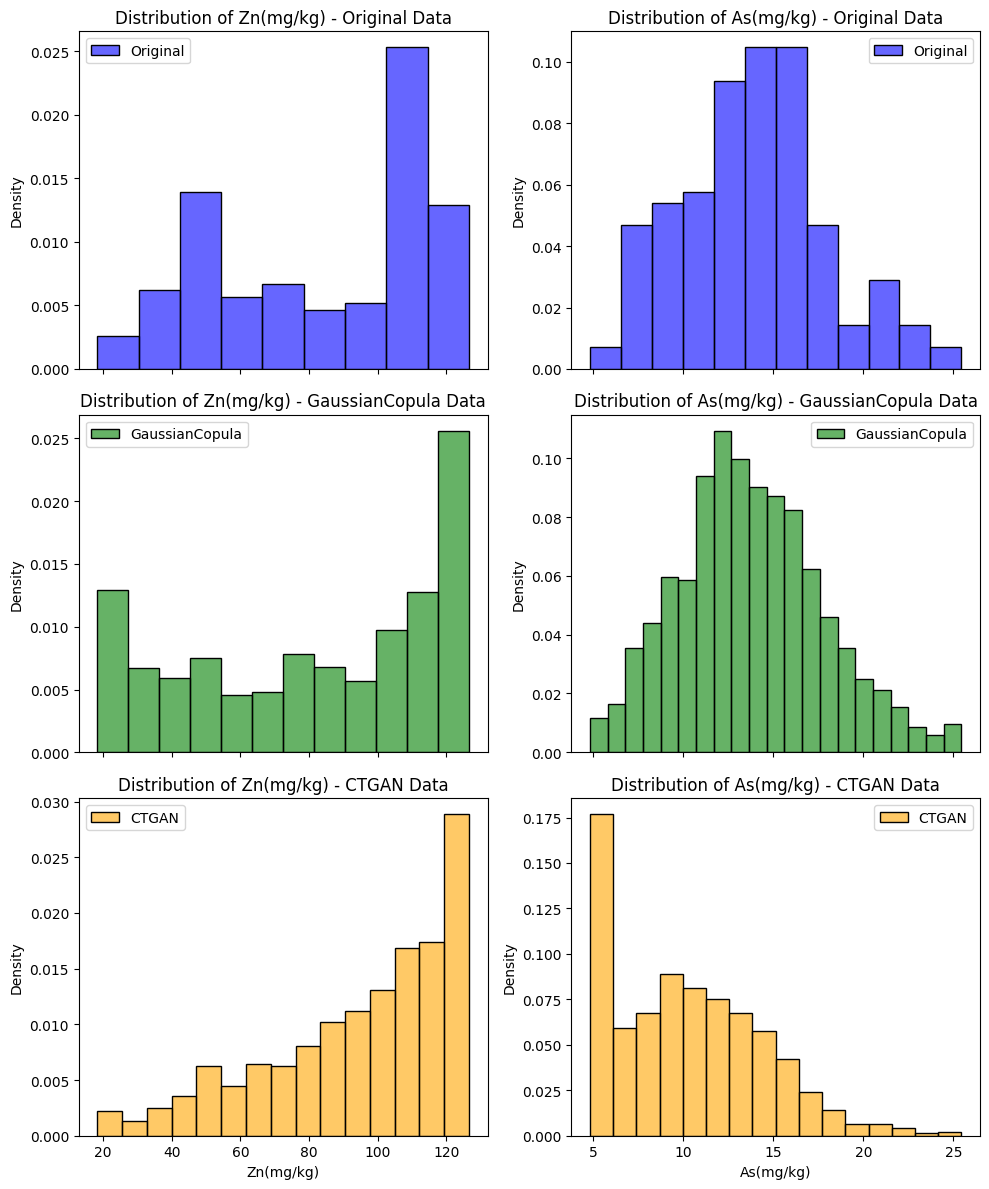

In [30]:
# Define datasets and their properties
datasets = [
    {'data': original_data, 'label': 'Original', 'color': 'blue'},
    {'data': gaussian_data, 'label': 'GaussianCopula', 'color': 'green'},
    {'data': ctgan_data, 'label': 'CTGAN', 'color': 'orange'}
]
variables = ['Zn(mg/kg)', 'As(mg/kg)']

# Create figure with subplots (3 rows per variable, 2 columns for Zn and As)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12), sharex='col')

# Plot histograms for each variable
for col_idx, var in enumerate(variables):
    for row_idx, dataset in enumerate(datasets):
        sns.histplot(
            data=dataset['data'],
            x=var,
            color=dataset['color'],
            label=dataset['label'],
            alpha=0.6,
            stat='density',
            ax=axes[row_idx, col_idx]
        )
        axes[row_idx, col_idx].set_title(f'Distribution of {var} - {dataset["label"]} Data')
        axes[row_idx, col_idx].set_xlabel(var)
        axes[row_idx, col_idx].set_ylabel('Density')
        axes[row_idx, col_idx].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Exploratory Analysis

In [31]:
# Keep only numeric columns for analysis
data = gaussian_data.copy()
numeric_data = data.iloc[:,2:]
numeric_data.shape

(1061, 16)

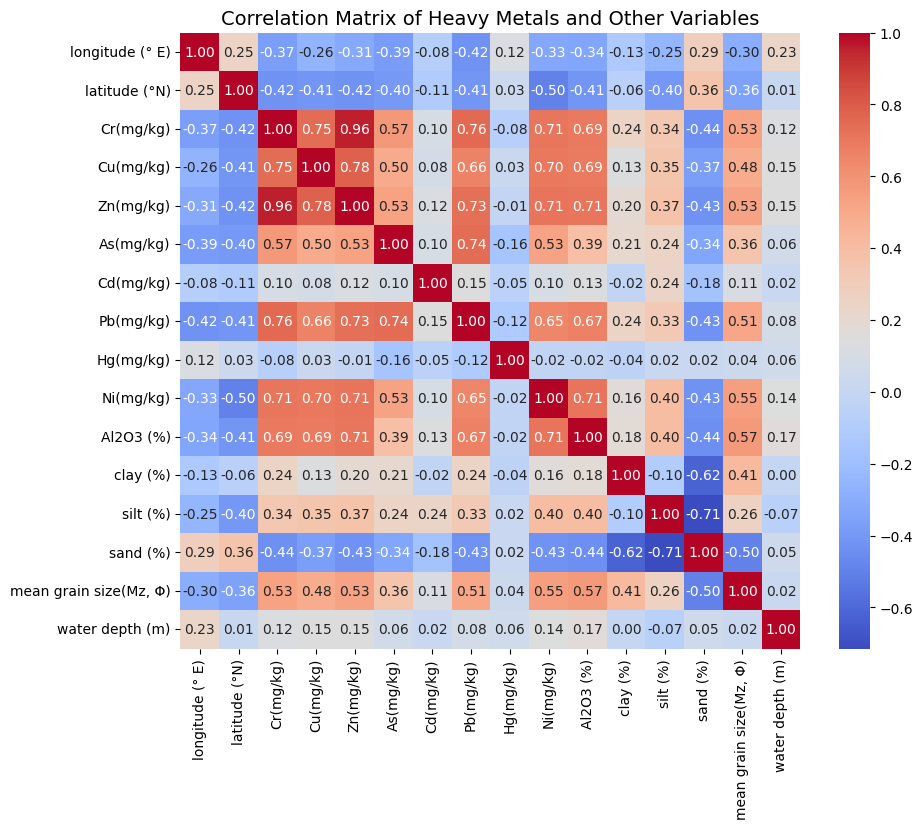


Correlation with Arsenic (As):
                         As(mg/kg)
As(mg/kg)                1.000000
Pb(mg/kg)                0.739692
Cr(mg/kg)                0.571789
Zn(mg/kg)                0.532165
Ni(mg/kg)                0.525729
Cu(mg/kg)                0.496696
Al2O3 (%)                0.389910
mean grain size(Mz, Φ)   0.359365
silt (%)                 0.243541
clay (%)                 0.208638
Cd(mg/kg)                0.099076
water depth (m)          0.063731
Hg(mg/kg)               -0.163482
sand (%)                -0.338179
longitude (° E)         -0.385694
latitude (°N)           -0.395667

Correlation with Zinc (Zn):
                         Zn(mg/kg)
Zn(mg/kg)                1.000000
Cr(mg/kg)                0.956823
Cu(mg/kg)                0.784994
Pb(mg/kg)                0.729867
Ni(mg/kg)                0.714754
Al2O3 (%)                0.707804
As(mg/kg)                0.532165
mean grain size(Mz, Φ)   0.528397
silt (%)                 0.370139
clay (%)           

In [32]:
#Correlation heatmap
plt.figure(figsize=(10, 8))
corr_df = numeric_data.corr()
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Heavy Metals and Other Variables", fontsize=14)
plt.show()

# Correlation with Arsenic
as_corr = corr_df[['As(mg/kg)']].sort_values(by='As(mg/kg)', ascending=False)

# Correlation with Zinc
zn_corr = corr_df[['Zn(mg/kg)']].sort_values(by='Zn(mg/kg)', ascending=False)

# Display the two tables
print("\nCorrelation with Arsenic (As):\n", as_corr)
print("\nCorrelation with Zinc (Zn):\n", zn_corr)


Stationary Test(ADF AND PP Test)

In [33]:

# Initialize a list to store results
results = []

# Function to perform ADF and PP tests and return results
def stationary_tests(series, col_name):
    result_row = {'Feature': col_name}
    
    # ADF Test
    try:
        adf_result = adfuller(series, autolag='AIC')
        result_row['ADF_Statistic'] = round(adf_result[0], 4)
        result_row['ADF_p-value'] = round(adf_result[1], 4)
        result_row['ADF_Result'] = 'Stationary' if adf_result[1] < 0.05 else 'Non-Stationary'
    except Exception as e:
        result_row['ADF_Statistic'] = None
        result_row['ADF_p-value'] = None
        result_row['ADF_Result'] = f'Error: {str(e)}'
    
    # PP Test
    try:
        pp = PhillipsPerron(series)
        result_row['PP_Statistic'] = round(pp.stat, 4)
        result_row['PP_p-value'] = round(pp.pvalue, 4)
        result_row['PP_Result'] = 'Stationary' if pp.pvalue < 0.05 else 'Non-Stationary'
    except Exception as e:
        result_row['PP_Statistic'] = None
        result_row['PP_p-value'] = None
        result_row['PP_Result'] = f'Error: {str(e)}'
    
    return result_row

# Perform tests for each numerical column
for col in numeric_data.columns:
    series = numeric_data[col].dropna()  # Drop NaNs if any
    if len(series) > 1:  # Ensure enough data points
        result = stationary_tests(series, col)
        results.append(result)
    else:
        results.append({
            'Feature': col,
            'ADF_Statistic': None,
            'ADF_p-value': None,
            'ADF_Result': 'Insufficient data',
            'PP_Statistic': None,
            'PP_p-value': None,
            'PP_Result': 'Insufficient data'
        })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Reorder columns for clarity
results_df = results_df[[
    'Feature', 
    'ADF_Statistic', 'ADF_p-value', 
    'PP_Statistic', 'PP_p-value', 
]]

# Display the table
print("\nStationarity Test Results:")
print(results_df.to_string(index=False))




Stationarity Test Results:
               Feature  ADF_Statistic  ADF_p-value  PP_Statistic  PP_p-value
       longitude (° E)       -12.7651       0.0000      -28.0836         0.0
         latitude (°N)        -5.6995       0.0000      -32.0888         0.0
             Cr(mg/kg)       -20.1125       0.0000      -30.3201         0.0
             Cu(mg/kg)       -28.7184       0.0000      -29.8236         0.0
             Zn(mg/kg)       -20.1190       0.0000      -31.4617         0.0
             As(mg/kg)       -15.9697       0.0000      -30.7471         0.0
             Cd(mg/kg)        -2.2201       0.1990      -10.9336         0.0
             Pb(mg/kg)       -19.8581       0.0000      -29.9189         0.0
             Hg(mg/kg)       -31.5513       0.0000      -31.5438         0.0
             Ni(mg/kg)        -4.7203       0.0001      -30.5088         0.0
             Al2O3 (%)       -27.6299       0.0000      -28.4704         0.0
              clay (%)       -30.3454       0.00

Normality test(Jaquera-Bera Test)

In [34]:
# Run Jarque-Bera test for each column
jb_results = []
for col in numeric_data.columns:
    stat, p_value = jarque_bera(numeric_data[col].dropna())
    jb_results.append({
        'Variable': col,
        'JB Statistic': stat,
        'p-value': p_value,
        
    })
# Create DataFrame of results
jb_df = pd.DataFrame(jb_results)

# Display
print(jb_df)



                  Variable  JB Statistic        p-value
0          longitude (° E)     67.194020   2.564507e-15
1            latitude (°N)     55.348514   9.576855e-13
2                Cr(mg/kg)     79.764785   4.778560e-18
3                Cu(mg/kg)     97.202241   7.812708e-22
4                Zn(mg/kg)     99.374300   2.637211e-22
5                As(mg/kg)     20.346755   3.817318e-05
6                Cd(mg/kg)   8571.519757   0.000000e+00
7                Pb(mg/kg)     46.600282   7.601117e-11
8                Hg(mg/kg)     68.565429   1.291833e-15
9                Ni(mg/kg)    369.692678   5.275396e-81
10               Al2O3 (%)    489.823760  4.326354e-107
11                clay (%)    254.643643   5.067987e-56
12                silt (%)    115.404644   8.713646e-26
13                sand (%)    163.062492   3.903280e-36
14  mean grain size(Mz, Φ)    113.063535   2.809088e-25
15         water depth (m)      2.158135   3.399123e-01


Model Development

Elman Neural Network

In [ ]:
def safe_mape(y_true, y_pred):
    """Calculate MAPE, avoiding division by zero."""
    # Handle NaN and infinite values
    mask = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true != 0)
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0


def calculate_nse(y_true, y_pred):
    """Calculate Nash-Sutcliffe Efficiency (NSE)."""
    # Handle NaN values
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if np.sum(mask) == 0:
        return np.nan
    
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    mean_obs = np.mean(y_true_clean)
    ss_res = np.sum((y_true_clean - y_pred_clean) ** 2)
    ss_tot = np.sum((y_true_clean - mean_obs) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan


def calculate_pbias(y_true, y_pred):
    
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if np.sum(mask) == 0:
        return np.nan
    
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    return np.sum(y_true_clean - y_pred_clean) / np.sum(y_true_clean) * 100 if np.sum(y_true_clean) != 0 else np.nan


def calculate_mae(y_true, y_pred):
    
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))


def calculate_rmse(y_true, y_pred):
    
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if np.sum(mask) == 0:
        return np.nan
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))


def calculate_pcc(y_true, y_pred):
    
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if np.sum(mask) < 2:
        return np.nan
    
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    # Check if there's variance in both arrays
    if np.std(y_true_clean) == 0 or np.std(y_pred_clean) == 0:
        return np.nan
        
    try:
        pcc, p_value = pearsonr(y_true_clean, y_pred_clean)
        return pcc if np.isfinite(pcc) else np.nan
    except:
        return np.nan


def calculate_lag_correlation(y_true, y_pred, lag=1):
    """Calculate correlation between predictions and lagged true values."""
    if len(y_true) < lag + 1:
        return np.nan
    
    mask_true = np.isfinite(y_true[lag:])
    mask_pred = np.isfinite(y_pred[:-lag])
    mask = mask_true & mask_pred
    
    if np.sum(mask) < 2:
        return np.nan
        
    try:
        return pearsonr(y_true[lag:][mask], y_pred[:-lag][mask])[0]
    except:
        return np.nan


def calculate_morans_i(y_pred, coords, k=3):
    """Calculate Moran's I for spatial autocorrelation."""
    # Remove NaN values
    mask = np.isfinite(y_pred)
    if np.sum(mask) < k + 1:
        return np.nan
    
    y_pred_clean = y_pred[mask]
    coords_clean = coords[mask]
    
    if len(y_pred_clean) < k + 1:
        return np.nan
    
    try:
        nbrs = NearestNeighbors(n_neighbors=min(k, len(coords_clean)-1)).fit(coords_clean)
        distances, indices = nbrs.kneighbors(coords_clean)
        
        # Avoid division by zero
        w = 1 / (distances + 1e-8)  # Increased epsilon
        w = w / (w.sum(axis=1, keepdims=True) + 1e-8)  # Normalize with safety
        
        y_pred_clean = y_pred_clean.flatten()
        y_mean = np.mean(y_pred_clean)
        n = len(y_pred_clean)
        
        num = 0
        den = np.sum((y_pred_clean - y_mean) ** 2)
        
        if den == 0:
            return np.nan
            
        for i in range(n):
            for j in range(min(k, w.shape[1])):
                if indices[i, j] < len(y_pred_clean):  # Safety check
                    num += w[i, j] * (y_pred_clean[i] - y_mean) * (y_pred_clean[indices[i, j]] - y_mean)
        
        w_sum = np.sum(w)
        return (n / w_sum) * (num / den) if w_sum != 0 and den != 0 else np.nan
    except:
        return np.nan


def create_weighted_knn_sequences(X_coords, X_features, y, k=3):
    """Create KNN sequences with distance-based weights."""
    if len(X_coords) < k:
        k = max(1, len(X_coords) - 1)
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_coords)
    distances, indices = nbrs.kneighbors(X_coords)
    
    # Improved weight calculation
    weights = 1 / (distances + 1e-8)  # Increased epsilon
    weights = weights / (weights.sum(axis=1, keepdims=True) + 1e-8)  # Normalize with safety
    
    X_seq, y_seq = [], []
    for i in range(len(X_features)):
        # Ensure indices are valid
        valid_indices = indices[i][indices[i] < len(X_features)]
        if len(valid_indices) == 0:
            valid_indices = [i]  # Use self if no valid neighbors
        
        seq = X_features[valid_indices[:k]] * weights[i][:len(valid_indices)][:, None]
        X_seq.append(seq)
        y_seq.append(y[i])
    
    return np.array(X_seq), np.array(y_seq)


class ImprovedElmanNetwork:
    def __init__(self, n_inputs, n_hidden, n_outputs, lr=0.01, l2_lambda=0.001):
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        self.lr = lr
        self.l2_lambda = l2_lambda

        # Improved weight initialization (Xavier/Glorot)
        limit_xh = np.sqrt(6 / (n_inputs + n_hidden))
        limit_ch = np.sqrt(6 / (n_hidden + n_hidden))
        limit_hy = np.sqrt(6 / (n_hidden + n_outputs))
        
        self.W_xh = np.random.uniform(-limit_xh, limit_xh, (n_inputs, n_hidden))
        self.W_ch = np.random.uniform(-limit_ch, limit_ch, (n_hidden, n_hidden))
        self.b_h = np.zeros((1, n_hidden))
        self.W_hy = np.random.uniform(-limit_hy, limit_hy, (n_hidden, n_outputs))
        self.b_y = np.zeros((1, n_outputs))

        # Adam parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0

        # Adam moments
        self.m_W_xh = np.zeros_like(self.W_xh)
        self.v_W_xh = np.zeros_like(self.W_xh)
        self.m_W_ch = np.zeros_like(self.W_ch)
        self.v_W_ch = np.zeros_like(self.W_ch)
        self.m_b_h = np.zeros_like(self.b_h)
        self.v_b_h = np.zeros_like(self.b_h)
        self.m_W_hy = np.zeros_like(self.W_hy)
        self.v_W_hy = np.zeros_like(self.W_hy)
        self.m_b_y = np.zeros_like(self.b_y)
        self.v_b_y = np.zeros_like(self.b_y)

        # Context layer
        self.context = np.zeros((1, n_hidden))

    def reset_context(self):
        self.context = np.zeros((1, self.n_hidden))

    def forward(self, x_seq):
        """Forward pass for a sequence."""
        h_states = []
        self.reset_context()
        
        for t in range(x_seq.shape[0]):
            x_t = x_seq[t:t+1]
            h_net = np.dot(x_t, self.W_xh) + np.dot(self.context, self.W_ch) + self.b_h
            
            # Use tanh activation with gradient clipping
            h = np.tanh(np.clip(h_net, -10, 10))
            h_states.append(h)
            self.context = h
            
        # Final output
        y_pred = np.dot(h_states[-1], self.W_hy) + self.b_y
        return y_pred, h_states

    def backward(self, x_seq, h_states, y_pred, y_true):
        """Backward pass with BPTT for sequence."""
        error = y_pred - y_true
        
        # Check for NaN in error
        if np.any(np.isnan(error)) or np.any(np.isinf(error)):
            return float('inf')
            
        loss = np.mean(error ** 2) + self.l2_lambda * (
            np.sum(self.W_xh ** 2) + np.sum(self.W_ch ** 2) + np.sum(self.W_hy ** 2)
        )

        # Output layer gradients
        dW_hy = np.dot(h_states[-1].T, error) / x_seq.shape[0] + 2 * self.l2_lambda * self.W_hy
        db_y = np.mean(error, axis=0, keepdims=True)
        dh = np.dot(error, self.W_hy.T) * (1.0 - h_states[-1] ** 2)

        # Recurrent gradients (BPTT)
        dW_xh = np.zeros_like(self.W_xh)
        dW_ch = np.zeros_like(self.W_ch)
        db_h = np.zeros_like(self.b_h)
        
        for t in reversed(range(x_seq.shape[0])):
            dW_xh += np.dot(x_seq[t:t+1].T, dh) / x_seq.shape[0]
            prev_h = h_states[t-1] if t > 0 else np.zeros_like(self.context)
            dW_ch += np.dot(prev_h.T, dh) / x_seq.shape[0]
            db_h += np.mean(dh, axis=0, keepdims=True)
            
            if t > 0:
                dh = np.dot(dh, self.W_ch.T) * (1.0 - h_states[t-1] ** 2)
                # Gradient clipping for vanishing gradient
                dh = np.clip(dh, -1, 1)

        # Add L2 regularization to weight gradients
        dW_xh += 2 * self.l2_lambda * self.W_xh
        dW_ch += 2 * self.l2_lambda * self.W_ch

        # Improved gradient clipping
        max_norm = 5.0  # Reduced from 12.0
        grads = [dW_xh, dW_ch, db_h, dW_hy, db_y]
        
        # Check for NaN gradients
        for i, grad in enumerate(grads):
            if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
                print(f"NaN/Inf gradient detected in gradient {i}")
                return float('inf')
        
        norm = np.sqrt(sum(np.sum(g ** 2) for g in grads))
        if norm > max_norm:
            scale = max_norm / norm
            grads = [g * scale for g in grads]
        
        dW_xh, dW_ch, db_h, dW_hy, db_y = grads

        # Adam update with improved numerical stability
        self.t += 1
        params = [
            (dW_xh, 'W_xh'),
            (dW_ch, 'W_ch'),
            (db_h, 'b_h'),
            (dW_hy, 'W_hy'),
            (db_y, 'b_y')
        ]
        
        for dparam, name in params:
            m = getattr(self, f'm_{name}')
            v = getattr(self, f'v_{name}')
            
            m = self.beta1 * m + (1 - self.beta1) * dparam
            v = self.beta2 * v + (1 - self.beta2) * (dparam ** 2)
            
            m_hat = m / (1 - self.beta1 ** self.t)
            v_hat = v / (1 - self.beta2 ** self.t)
            
            # Improved numerical stability
            update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
            # Clip updates to prevent exploding
            update = np.clip(update, -0.5, 0.5)
            
            param = getattr(self, name)
            param -= update
            
            # Check for NaN in parameters
            if np.any(np.isnan(param)) or np.any(np.isinf(param)):
                print(f"NaN/Inf parameter detected in {name}")
                return float('inf')
            
            setattr(self, f'm_{name}', m)
            setattr(self, f'v_{name}', v)
            setattr(self, name, param)

        return loss

    @staticmethod
    def load_and_preprocess_data(target='As(mg/kg)', corr_threshold=0.05, k=3, drop_cols=None, file_path="gaussian_synthetic_complete.csv"):
        """Load and create weighted KNN sequences with improved preprocessing."""
        if drop_cols is None:
            drop_cols = ['station', 'sample number', 'longitude (° E)', 'latitude (°N)']

        df = pd.read_csv(file_path)
        print(f"Initial data shape: {df.shape}")
        
        # Handle missing values more carefully
        df = df.dropna()
        print(f"After dropping NaN: {df.shape}")

        # Store coordinates before any transformations
        coords = df[['longitude (° E)', 'latitude (°N)']].values
        y = df[target].values
        
        print(f"Target {target} - Min: {y.min():.3f}, Max: {y.max():.3f}, Mean: {y.mean():.3f}")

        # Prepare features
        X = df.drop([target] + drop_cols, axis=1, errors='ignore')
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X = X[numeric_cols]
        
        print(f"Features before selection: {X.shape[1]}")

        # Improved log transformation - only for highly skewed features
        for col in numeric_cols:
            if col in X.columns:
                skewness = pd.Series(X[col]).skew()
                if abs(skewness) > 2 and X[col].min() >= 0:  # Only transform highly skewed data
                    X[col] = np.log1p(X[col])

        # Feature selection based on correlation
        corr = X.corrwith(pd.Series(y)).abs()
        selected_features = corr[corr > corr_threshold].index.tolist()
        if not selected_features:
            # If no features meet threshold, select top features
            selected_features = corr.nlargest(min(10, len(corr))).index.tolist()
        
        X = X[selected_features]
        print(f"Selected features ({len(selected_features)}): {selected_features}")

        # Improved scaling - use StandardScaler for better numerical stability
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Improved target scaling
        y_mean, y_std = np.mean(y), np.std(y)
        if y_std == 0:
            y_std = 1  # Avoid division by zero
        y_scaled = (y - y_mean) / y_std
        
        print(f"Y scaling - Mean: {y_mean:.3f}, Std: {y_std:.3f}")
        
        # Reshape target
        y_scaled = y_scaled.reshape(-1, 1)

        # Create weighted KNN sequences
        X_seq, y_seq = create_weighted_knn_sequences(coords, X_scaled, y_scaled, k=k)
        
        print(f"Sequence shape: {X_seq.shape}")

        # Spatial clustering for split
        n_clusters = min(20, len(coords) // 5)  # Adjust clusters based on data size
        if n_clusters < 3:
            n_clusters = 3
            
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(coords)
        cluster_labels = kmeans.labels_

        return X_seq, y_seq, selected_features, y_mean, y_std, coords, cluster_labels, scaler

    def train_epoch(self, X_seq, y_seq):
        """Train one epoch over sequences."""
        if X_seq.shape[0] != y_seq.shape[0]:
            raise ValueError("Sequence mismatch")
            
        total_loss = 0.0
        valid_samples = 0
        indices = np.random.permutation(X_seq.shape[0])
        
        for i in indices:
            try:
                y_pred, h_states = self.forward(X_seq[i])
                loss = self.backward(X_seq[i], h_states, y_pred, y_seq[i:i+1])
                
                if np.isfinite(loss):
                    total_loss += loss
                    valid_samples += 1
                else:
                    print(f"Invalid loss at sample {i}: {loss}")
                    
            except Exception as e:
                print(f"Error processing sample {i}: {e}")
                continue
                
        return total_loss / max(valid_samples, 1)

    def predict(self, X_seq):
        """Predict for sequences."""
        y_pred = np.zeros((X_seq.shape[0], self.n_outputs))
        
        for i in range(X_seq.shape[0]):
            try:
                self.reset_context()
                y, _ = self.forward(X_seq[i])
                y_pred[i] = y
            except Exception as e:
                print(f"Error predicting sample {i}: {e}")
                y_pred[i] = np.nan
                
        return y_pred

    @staticmethod
    def select_hidden_nodes(n_inputs, n_outputs):
        """Select reasonable hidden node candidates."""
        base = max(4, int(np.sqrt(n_inputs * n_outputs)))
        return [base, base + 2, base + 4, base + 6, base + 8]


def improved_tune_hyperparameters(target='As(mg/kg)', file_path="gaussian_synthetic_complete.csv", max_epochs=50):
    """Improved hyperparameter tuning."""
    k_values = [2, 3, 4]
    best_val_loss = float('inf')
    best_params = {'k': 3, 'n_hidden': 8}
    best_model = None
    results = []

    for k in k_values:
        print(f"\n=== Testing k={k} ===")
        
        try:
            # Load data with current k
            X_seq, y_seq, selected_features, y_mean, y_std, coords, cluster_labels, scaler = \
                ImprovedElmanNetwork.load_and_preprocess_data(target=target, k=k, file_path=file_path)
            
            # Cluster-based split
            unique_clusters = np.unique(cluster_labels)
            n_train = max(1, int(0.7 * len(unique_clusters)))
            n_val = max(1, int(0.2 * len(unique_clusters)))
            
            train_clusters = unique_clusters[:n_train]
            val_clusters = unique_clusters[n_train:n_train+n_val]
            test_clusters = unique_clusters[n_train+n_val:]
            
            train_idx = np.isin(cluster_labels, train_clusters)
            val_idx = np.isin(cluster_labels, val_clusters)
            test_idx = np.isin(cluster_labels, test_clusters)
            
            X_train_seq = X_seq[train_idx]
            y_train_seq = y_seq[train_idx]
            X_val_seq = X_seq[val_idx]
            y_val_seq = y_seq[val_idx]
            
            if len(X_train_seq) == 0 or len(X_val_seq) == 0:
                print(f"Insufficient data for k={k}")
                continue
            
            print(f"Train: {len(X_train_seq)}, Val: {len(X_val_seq)}")
            
            n_inputs = X_train_seq.shape[2]
            n_outputs = 1
            
            hidden_candidates = ImprovedElmanNetwork.select_hidden_nodes(n_inputs, n_outputs)
            
            for n_hidden in hidden_candidates:
                print(f"  Testing hidden_nodes={n_hidden}...")
                
                # Create model with adjusted learning rate
                rnn = ImprovedElmanNetwork(n_inputs, n_hidden, n_outputs, lr=0.005, l2_lambda=0.001)
                
                best_epoch_loss = float('inf')
                patience_counter = 0
                patience = 15
                
                for epoch in range(max_epochs):
                    train_loss = rnn.train_epoch(X_train_seq, y_train_seq)
                    
                    if not np.isfinite(train_loss):
                        print(f"    Invalid training loss at epoch {epoch+1}")
                        break
                    
                    # Validate every 5 epochs
                    if (epoch + 1) % 5 == 0:
                        val_pred = rnn.predict(X_val_seq)
                        val_loss = np.mean((val_pred - y_val_seq) ** 2)
                        
                        if np.isfinite(val_loss):
                            if val_loss < best_epoch_loss:
                                best_epoch_loss = val_loss
                                patience_counter = 0
                            else:
                                patience_counter += 1
                            
                            if patience_counter >= patience:
                                print(f"Early stopping at epoch {epoch+1}")
                                break
                        else:
                            print(f"Invalid validation loss at epoch {epoch+1}")
                            break
                
                final_val_pred = rnn.predict(X_val_seq)
                final_val_loss = np.mean((final_val_pred - y_val_seq) ** 2)
                
                if np.isfinite(final_val_loss):
                    results.append({
                        'k': k,
                        'n_hidden': n_hidden,
                        'val_loss': final_val_loss
                    })
                    
                    print(f"    Final val loss: {final_val_loss:.6f}")
                    
                    if final_val_loss < best_val_loss:
                        best_val_loss = final_val_loss
                        best_params = {'k': k, 'n_hidden': n_hidden}
                        best_model = rnn
                else:
                    print(f"Invalid final validation loss")
                    
        except Exception as e:
            print(f"Error with k={k}: {e}")
            continue
    
    print(f"\nBest parameters: {best_params} (val_loss: {best_val_loss:.6f})")
    return best_params, best_model, results


# Example usage and main training loop
if __name__ == "__main__":
    # For Zn prediction
    target_metal = 'As(mg/kg)'
    print(f"=== Training for {target_metal} ===")
    
    # Tune hyperparameters
    best_params, best_model, tuning_results = improved_tune_hyperparameters(
        target=target_metal, 
        file_path="gaussian_synthetic_complete.csv"
    )
    
    # Load data with best parameters
    X_seq, y_seq, selected_features, y_mean, y_std, coords, cluster_labels, scaler = \
        ImprovedElmanNetwork.load_and_preprocess_data(
            target=target_metal, 
            k=best_params['k'], 
            file_path="gaussian_synthetic_complete.csv"
        )
    
    # Final data split
    unique_clusters = np.unique(cluster_labels)
    n_train = max(1, int(0.7 * len(unique_clusters)))
    n_val = max(1, int(0.2 * len(unique_clusters)))
    
    train_clusters = unique_clusters[:n_train]
    val_clusters = unique_clusters[n_train:n_train+n_val]
    test_clusters = unique_clusters[n_train+n_val:]
    
    train_idx = np.isin(cluster_labels, train_clusters)
    val_idx = np.isin(cluster_labels, val_clusters)
    test_idx = np.isin(cluster_labels, test_clusters)
    
    X_train_seq = X_seq[train_idx]
    y_train_seq = y_seq[train_idx]
    X_val_seq = X_seq[val_idx]
    y_val_seq = y_seq[val_idx]
    X_test_seq = X_seq[test_idx]
    y_test_seq = y_seq[test_idx]
    
    print(f"Final split - Train: {len(X_train_seq)}, Val: {len(X_val_seq)}, Test: {len(X_test_seq)}")
    
    # Final model training
    n_inputs = X_train_seq.shape[2]
    rnn = ImprovedElmanNetwork(n_inputs, best_params['n_hidden'], 1, lr=0.005, l2_lambda=0.001)
    
    n_epochs = 200
    patience = 30
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training with learning rate scheduling
    initial_lr = 0.005
    
    for epoch in range(n_epochs):
        # Learning rate decay
        if epoch > 0 and epoch % 50 == 0:
            rnn.lr *= 0.8
        
        train_loss = rnn.train_epoch(X_train_seq, y_train_seq)
        
        if not np.isfinite(train_loss):
            print(f"Training failed at epoch {epoch+1}")
            break
        
        # Validation
        if (epoch + 1) % 10 == 0:
            val_pred = rnn.predict(X_val_seq)
            val_loss = np.mean((val_pred - y_val_seq) ** 2)
            
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {rnn.lr:.6f}")
            
            if np.isfinite(val_loss):
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
    
    # Final predictions and evaluation
    y_pred_norm = rnn.predict(X_test_seq)
    y_pred = y_pred_norm * y_std + y_mean
    y_test_denorm = y_test_seq * y_std + y_mean
    
    # Apply reasonable clipping based on target
    if target_metal == 'Zn(mg/kg)':
        y_pred = np.clip(y_pred, 0, 200)  # Reasonable range for Zn
    elif target_metal == 'As(mg/kg)':
        y_pred = np.clip(y_pred, 0, 50)   # Reasonable range for As
    
    # Flatten arrays for metric calculations
    y_test_flat = y_test_denorm.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Calculate all metrics with improved error handling
    print(f"\n=== Final Results for {target_metal} ===")
    
    mape = safe_mape(y_test_flat, y_pred_flat)
    nse = calculate_nse(y_test_flat, y_pred_flat)
    pbias = calculate_pbias(y_test_flat, y_pred_flat)
    mae = calculate_mae(y_test_flat, y_pred_flat)
    rmse = calculate_rmse(y_test_flat, y_pred_flat)
    pcc = calculate_pcc(y_test_flat, y_pred_flat)
    morans_i = calculate_morans_i(y_pred_flat, coords[test_idx], k=3)
    
    print(f"Test MAPE: {mape:.2f}%" if np.isfinite(mape) else "Test MAPE: N/A")
    print(f"Test NSE: {nse:.4f}" if np.isfinite(nse) else "Test NSE: N/A")
    print(f"Test PBIAS: {pbias:.2f}%" if np.isfinite(pbias) else "Test PBIAS: N/A")
    print(f"Test MAE: {mae:.4f}" if np.isfinite(mae) else "Test MAE: N/A")
    print(f"Test RMSE: {rmse:.4f}" if np.isfinite(rmse) else "Test RMSE: N/A")
    print(f"Test PCC: {pcc:.4f}" if np.isfinite(pcc) else "Test PCC: N/A")
    print(f"Test Moran's I: {morans_i:.4f}" if np.isfinite(morans_i) else "Test Moran's I: N/A")
    
    # Additional diagnostic information
    print(f"\nDiagnostic Information:")
    print(f"Predictions - Min: {y_pred_flat.min():.3f}, Max: {y_pred_flat.max():.3f}, Mean: {y_pred_flat.mean():.3f}")
    print(f"True values - Min: {y_test_flat.min():.3f}, Max: {y_test_flat.max():.3f}, Mean: {y_test_flat.mean():.3f}")
    print(f"Prediction std: {np.std(y_pred_flat):.3f}")
    print(f"True values std: {np.std(y_test_flat):.3f}")
    
    # Check for prediction issues
    nan_predictions = np.sum(np.isnan(y_pred_flat))
    inf_predictions = np.sum(np.isinf(y_pred_flat))
    if nan_predictions > 0 or inf_predictions > 0:
        print(f"WARNING: {nan_predictions} NaN predictions, {inf_predictions} Inf predictions")
    
    # Save results for comparison
    results_dict = {
        'target': target_metal,
        'best_params': best_params,
        'mape': mape,
        'nse': nse,
        'pbias': pbias,
        'mae': mae,
        'rmse': rmse,
        'pcc': pcc,
        'morans_i': morans_i,
        'selected_features': selected_features,
        'n_train': len(X_train_seq),
        'n_val': len(X_val_seq),
        'n_test': len(X_test_seq)
    }
    
    print(f"\nTraining completed successfully!")
    
    
def compare_models_for_multiple_targets():
    """Compare model performance across different heavy metals."""
    targets = ['Zn(mg/kg)', 'As(mg/kg)', 'Pb(mg/kg)', 'Cu(mg/kg)', 'Cr(mg/kg)']
    all_results = []
    
    for target in targets:
        print(f"\n{'='*50}")
        print(f"Training model for {target}")
        print(f"{'='*50}")
        
        try:
            # Tune hyperparameters for this target
            best_params, best_model, tuning_results = improved_tune_hyperparameters(
                target=target, 
                file_path="gaussian_synthetic_complete.csv",
                max_epochs=30  # Reduced for multiple targets
            )
            
            if best_model is None:
                print(f"Failed to train model for {target}")
                continue
            
            # Load data with best parameters
            X_seq, y_seq, selected_features, y_mean, y_std, coords, cluster_labels, scaler = \
                ImprovedElmanNetwork.load_and_preprocess_data(
                    target=target, 
                    k=best_params['k'], 
                    file_path="gaussian_synthetic_complete.csv"
                )
            
            # Split data
            unique_clusters = np.unique(cluster_labels)
            n_train = max(1, int(0.7 * len(unique_clusters)))
            n_val = max(1, int(0.2 * len(unique_clusters)))
            
            train_clusters = unique_clusters[:n_train]
            val_clusters = unique_clusters[n_train:n_train+n_val]
            test_clusters = unique_clusters[n_train+n_val:]
            
            train_idx = np.isin(cluster_labels, train_clusters)
            val_idx = np.isin(cluster_labels, val_clusters)
            test_idx = np.isin(cluster_labels, test_clusters)
            
            X_test_seq = X_seq[test_idx]
            y_test_seq = y_seq[test_idx]
            
            # Make predictions
            y_pred_norm = best_model.predict(X_test_seq)
            y_pred = y_pred_norm * y_std + y_mean
            y_test_denorm = y_test_seq * y_std + y_mean
            
            # Apply target-specific clipping
            if target == 'Zn(mg/kg)':
                y_pred = np.clip(y_pred, 0, 200)
            elif target == 'As(mg/kg)':
                y_pred = np.clip(y_pred, 0, 50)
            elif target == 'Pb(mg/kg)':
                y_pred = np.clip(y_pred, 0, 100)
            elif target == 'Cu(mg/kg)':
                y_pred = np.clip(y_pred, 0, 150)
            elif target == 'Cr(mg/kg)':
                y_pred = np.clip(y_pred, 0, 100)
            
            # Calculate metrics
            y_test_flat = y_test_denorm.flatten()
            y_pred_flat = y_pred.flatten()
            
            results = {
                'target': target,
                'k': best_params['k'],
                'n_hidden': best_params['n_hidden'],
                'mape': safe_mape(y_test_flat, y_pred_flat),
                'nse': calculate_nse(y_test_flat, y_pred_flat),
                'pbias': calculate_pbias(y_test_flat, y_pred_flat),
                'mae': calculate_mae(y_test_flat, y_pred_flat),
                'rmse': calculate_rmse(y_test_flat, y_pred_flat),
                'pcc': calculate_pcc(y_test_flat, y_pred_flat),
                'morans_i': calculate_morans_i(y_pred_flat, coords[test_idx], k=3),
                'n_features': len(selected_features),
                'n_test': len(y_test_flat)
            }
            
            all_results.append(results)
            
            print(f"\nResults for {target}:")
            for metric, value in results.items():
                if metric not in ['target', 'k', 'n_hidden', 'n_features', 'n_test']:
                    if np.isfinite(value):
                        if 'bias' in metric.lower() or 'mape' in metric.lower():
                            print(f"  {metric}: {value:.2f}%")
                        else:
                            print(f"  {metric}: {value:.4f}")
                    else:
                        print(f"  {metric}: N/A")
            
        except Exception as e:
            print(f"Error training model for {target}: {e}")
            continue
    
    # Summary table
    if all_results:
        print(f"\n{'='*80}")
        print("SUMMARY TABLE")
        print(f"{'='*80}")
        print(f"{'Target':<12} {'MAPE%':<8} {'NSE':<8} {'PBIAS%':<8} {'MAE':<8} {'RMSE':<8} {'PCC':<8}")
        print(f"{'-'*80}")
        
        for result in all_results:
            mape_str = f"{result['mape']:.1f}" if np.isfinite(result['mape']) else "N/A"
            nse_str = f"{result['nse']:.3f}" if np.isfinite(result['nse']) else "N/A"
            pbias_str = f"{result['pbias']:.1f}" if np.isfinite(result['pbias']) else "N/A"
            mae_str = f"{result['mae']:.2f}" if np.isfinite(result['mae']) else "N/A"
            rmse_str = f"{result['rmse']:.2f}" if np.isfinite(result['rmse']) else "N/A"
            pcc_str = f"{result['pcc']:.3f}" if np.isfinite(result['pcc']) else "N/A"
            
            print(f"{result['target']:<12} {mape_str:<8} {nse_str:<8} {pbias_str:<8} {mae_str:<8} {rmse_str:<8} {pcc_str:<8}")
    
    return all_results


def debug_training_issues():
    """Debug common training issues."""
    print("=== Training Debug Mode ===")
    
    # Load data for Zn
    target = 'As(mg/kg)'
    X_seq, y_seq, selected_features, y_mean, y_std, coords, cluster_labels, scaler = \
        ImprovedElmanNetwork.load_and_preprocess_data(
            target=target, 
            k=3, 
            file_path="/kaggle/input/private-new-dataset/gaussian_data.csv"
        )
    
    print(f"Data loaded successfully:")
    print(f"  X_seq shape: {X_seq.shape}")
    print(f"  y_seq shape: {y_seq.shape}")
    print(f"  Selected features: {len(selected_features)}")
    print(f"  Y statistics - Mean: {y_mean:.3f}, Std: {y_std:.3f}")
    
    # Check for data issues
    print(f"\nData quality check:")
    print(f"  X_seq - NaN: {np.sum(np.isnan(X_seq))}, Inf: {np.sum(np.isinf(X_seq))}")
    print(f"  y_seq - NaN: {np.sum(np.isnan(y_seq))}, Inf: {np.sum(np.isinf(y_seq))}")
    print(f"  X_seq range: [{np.min(X_seq):.3f}, {np.max(X_seq):.3f}]")
    print(f"  y_seq range: [{np.min(y_seq):.3f}, {np.max(y_seq):.3f}]")
    
    # Simple split for testing
    n_train = int(0.8 * len(X_seq))
    X_train = X_seq[:n_train]
    y_train = y_seq[:n_train]
    X_test = X_seq[n_train:]
    y_test = y_seq[n_train:]
    
    print(f"\nSimple split - Train: {len(X_train)}, Test: {len(X_test)}")
    
    # Test very simple model
    n_inputs = X_train.shape[2]
    rnn = ImprovedElmanNetwork(n_inputs, 6, 1, lr=0.01, l2_lambda=0.001)
    
    print(f"\nTesting simple model (6 hidden units):")
    
    for epoch in range(10):
        train_loss = rnn.train_epoch(X_train, y_train)
        test_pred = rnn.predict(X_test)
        test_loss = np.mean((test_pred - y_test) ** 2)
        
        print(f"  Epoch {epoch+1}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
        
        if not np.isfinite(train_loss) or not np.isfinite(test_loss):
            print("  ERROR: Non-finite loss detected!")
            break
        
        # Check predictions
        pred_stats = f"Pred range: [{np.min(test_pred):.3f}, {np.max(test_pred):.3f}]"
        print(f"    {pred_stats}")
    
    return X_seq, y_seq, rnn


# Additional utility function for model analysis
def analyze_model_weights(model):
    """Analyze model weights for debugging."""
    print("=== Weight Analysis ===")
    
    weights = {
        'W_xh': model.W_xh,
        'W_ch': model.W_ch,
        'W_hy': model.W_hy,
        'b_h': model.b_h,
        'b_y': model.b_y
    }
    
    for name, weight in weights.items():
        print(f"{name}:")
        print(f"  Shape: {weight.shape}")
        print(f"  Range: [{np.min(weight):.6f}, {np.max(weight):.6f}]")
        print(f"  Mean: {np.mean(weight):.6f}, Std: {np.std(weight):.6f}")
        print(f"  NaN count: {np.sum(np.isnan(weight))}")
        print(f"  Inf count: {np.sum(np.isinf(weight))}")
        print()



Boosted tree Algorithm

In [ ]:
# Load and preprocess the data
def load_and_preprocess_data():
    data = pd.read_csv('gaussian_synthetic_complete.csv', encoding='latin-1')
    
    # Drop non-feature columns
    X = data.drop(['As(mg/kg)', 'Zn(mg/kg)'], axis=1)
    y_as = data['As(mg/kg)'].values
    y_zn = data['Zn(mg/kg)'].values
    
    # Ensure numeric features (replace any non-numeric or NaN with 0)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    return X.values, y_as, y_zn, X.columns

# Metrics calculation
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    pcc = np.corrcoef(y_true, y_pred)[0, 1]
    
    # Safe MAPE
    nonzero_idx = y_true != 0
    mape = np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100
    pbias = np.sum(y_pred - y_true) / np.sum(y_true) * 100
    nse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

    
    return mae, rmse, pcc, mape, pbias,nse

# Training and evaluation
def train_and_evaluate_model(X, y, target_name, n_folds=10):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    param_grid = {
        'n_estimators': [20, 50, 100, 200, 300, 400, 500],
        'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5],
        'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8, 10],
    }
    
    model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        random_state=42
    )
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=kf,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    
    metrics_results = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        
        metrics = calculate_metrics(y_test, y_pred)
        metrics_results.append(metrics)
        
        print(f"\nFold {fold+1} - {target_name}:")
        print(f"MAE: {metrics[0]:.4f}, RMSE: {metrics[1]:.4f}, PCC: {metrics[2]:.4f}, MAPE: {metrics[3]:.4f}, PBIAS: {metrics[4]:.4f}%,NSE: {metrics[5]:.4f}")
    
    avg_metrics = np.mean(metrics_results, axis=0)
    print(f"\nAverage {target_name} Results:")
    print(f"MAE: {avg_metrics[0]:.4f}, RMSE: {avg_metrics[1]:.4f}, PCC: {avg_metrics[2]:.4f}, MAPE: {avg_metrics[3]:.4f}, PBIAS: {avg_metrics[4]:.4f}%,NSE: {metrics[5]:.4f}")
    
    return best_model, avg_metrics

# Main
def main():
    X, y_as, y_zn, feature_names = load_and_preprocess_data()
    
    print("\n=== Predicting Arsenic (As) ===")
    model_as, avg_metrics_as = train_and_evaluate_model(X, y_as, "Arsenic")
    
    
    print("\n=== Predicting Zinc (Zn) ===")
    model_zn, avg_metrics_zn = train_and_evaluate_model(X, y_zn, "Zinc")
    

if __name__ == "__main__":
    main()

Relevance Vector Machine

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

class BaseRVM:
    def __init__(self, kernel='rbf', degree=3, coef1=None, coef0=0.0, n_iter=3000, 
                 tol=1e-3, alpha=1e-6, threshold_alpha=1e9, beta=1e-6, 
                 beta_fixed=False, bias_used=True, verbose=False):
        self.kernel = kernel
        self.degree = degree
        self.coef1 = coef1
        self.coef0 = coef0
        self.n_iter = n_iter
        self.tol = tol
        self.alpha = alpha
        self.threshold_alpha = threshold_alpha
        self.beta = beta
        self.beta_fixed = beta_fixed
        self.bias_used = bias_used
        self.verbose = verbose

    def get_params(self, deep=True):
        params = {
            'kernel': self.kernel, 'degree': self.degree, 'coef1': self.coef1, 
            'coef0': self.coef0, 'n_iter': self.n_iter, 'tol': self.tol, 
            'alpha': self.alpha, 'threshold_alpha': self.threshold_alpha, 
            'beta': self.beta, 'beta_fixed': self.beta_fixed, 
            'bias_used': self.bias_used, 'verbose': self.verbose
        }
        return params

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def _apply_kernel(self, x, y):
        from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, polynomial_kernel
        if self.kernel == 'linear':
            phi = linear_kernel(x, y)
        elif self.kernel == 'rbf':
            phi = rbf_kernel(x, y, self.coef1)
        elif self.kernel == 'poly':
            phi = polynomial_kernel(x, y, self.degree, self.coef1, self.coef0)
        elif callable(self.kernel):
            phi = self.kernel(x, y)
            if len(phi.shape) != 2 or phi.shape[0] != x.shape[0]:
                raise ValueError("Invalid custom kernel output.")
        else:
            raise ValueError("Invalid kernel selection.")
        if self.bias_used:
            phi = np.append(phi, np.ones((phi.shape[0], 1)), axis=1)
        return phi

    def _prune(self):
        keep_alpha = self.alpha_ < self.threshold_alpha
        if not np.any(keep_alpha):
            keep_alpha[0] = True
            if self.bias_used:
                keep_alpha[-1] = True
        if self.bias_used:
            if not keep_alpha[-1]:
                self.bias_used = False
            self.relevance_ = self.relevance_[keep_alpha[:-1]]
        else:
            self.relevance_ = self.relevance_[keep_alpha]
        self.alpha_ = self.alpha_[keep_alpha]
        self.alpha_old = self.alpha_old[keep_alpha]
        self.gamma = self.gamma[keep_alpha]
        self.phi = self.phi[:, keep_alpha]
        self.sigma_ = self.sigma_[np.ix_(keep_alpha, keep_alpha)]
        self.m_ = self.m_[keep_alpha]

    def fit(self, X, y):
        from sklearn.utils.validation import check_X_y
        X, y = check_X_y(X, y)
        n_samples, n_features = X.shape
        self.phi = self._apply_kernel(X, X)
        n_basis_functions = self.phi.shape[1]
        self.relevance_ = X
        self.y = y
        self.alpha_ = self.alpha * np.ones(n_basis_functions)
        self.beta_ = self.beta
        self.m_ = np.zeros(n_basis_functions)
        self.alpha_old = self.alpha_
        
        for i in range(self.n_iter):
            self._posterior()
            self.gamma = 1 - self.alpha_*np.diag(self.sigma_)
            self.alpha_ = self.gamma/(self.m_ ** 2 + 1e-10)  # Added small constant for stability
            
            if not self.beta_fixed:
                residual_sum = np.sum((y - np.dot(self.phi, self.m_)) ** 2)
                self.beta_ = max((n_samples - np.sum(self.gamma))/residual_sum, 1e-6)
            
            self._prune()
            
            if self.verbose and i % 100 == 0:
                print(f"Iteration: {i}, Relevance Vectors: {self.relevance_.shape[0]}, Beta: {self.beta_:.6f}")
            
            delta = np.amax(np.absolute(self.alpha_ - self.alpha_old))
            if delta < self.tol and i > 10:
                break
            self.alpha_old = self.alpha_.copy()
        
        if self.bias_used:
            self.bias = self.m_[-1] if len(self.m_) > 0 else 0
        else:
            self.bias = None
        return self

class RVR(BaseRVM):
    def _posterior(self):
        try:
            i_s = np.diag(self.alpha_) + self.beta_ * np.dot(self.phi.T, self.phi)
            self.sigma_ = np.linalg.inv(i_s)
            self.m_ = self.beta_ * np.dot(self.sigma_, np.dot(self.phi.T, self.y))
        except np.linalg.LinAlgError:
            # Handle singular matrix
            i_s = np.diag(self.alpha_) + self.beta_ * np.dot(self.phi.T, self.phi)
            self.sigma_ = np.linalg.pinv(i_s)
            self.m_ = self.beta_ * np.dot(self.sigma_, np.dot(self.phi.T, self.y))

    def predict(self, X, eval_MSE=False):
        phi = self._apply_kernel(X, self.relevance_)
        y = np.dot(phi, self.m_)
        if eval_MSE:
            MSE = (1/self.beta_) + np.diag(np.dot(phi, np.dot(self.sigma_, phi.T)))
            return y, MSE
        return y

class MarineSedimentPredictor:
    """Enhanced predictor class for marine sediment analysis"""
    
    def __init__(self):
        self.features = [
            'longitude (° E)', 'latitude (°N)', 'Cr(mg/kg)', 'Cu(mg/kg)', 
            'Cd(mg/kg)', 'Pb(mg/kg)', 'Hg(mg/kg)', 'Ni(mg/kg)', 
            'Al2O3 (%)', 'clay (%)', 'silt (%)', 'sand (%)', 
            'mean grain size(Mz, Φ)', 'water depth (m)'
        ]
        self.models = {}
        self.scalers = {}
        self.metrics_history = {}
    
    def load_data(self, filepath: str) -> pd.DataFrame:
        """Load and validate the dataset"""
        try:
            df = pd.read_csv(filepath)
            print(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")
            
            # Check for missing features
            missing_features = [f for f in self.features if f not in df.columns]
            if missing_features:
                print(f"Warning: Missing features: {missing_features}")
                self.features = [f for f in self.features if f in df.columns]
            
            return df
        except Exception as e:
            print(f"Error loading data: {e}")
            return None
    
    def calculate_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Calculate comprehensive evaluation metrics"""
        # Handle potential division by zero in MAPE
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.inf
        
        # RMSE
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # MAE
        mae = mean_absolute_error(y_true, y_pred)
        
        # PCC
        pcc, _ = pearsonr(y_true, y_pred)
        
        # NSE
        nse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
        
        # PBIAS
        sum_y_true = np.sum(y_true)
        pbias = (100 / sum_y_true * np.sum(y_true - y_pred)) if sum_y_true != 0 else np.inf
        
        return {
            'RMSE': rmse, 'MAE': mae, 'MAPE': mape,
            'PCC': pcc, 'NSE': nse, 'PBIAS': pbias
        }
    
    def print_formatted_metrics(self, metrics: Dict[str, float], prefix: str = "Test"):
        """Print metrics in the requested format"""
        print(f"{prefix} MAPE: {metrics['MAPE']:.2f}%")
        print(f"{prefix} NSE: {metrics['NSE']:.4f}")
        print(f"{prefix} PBIAS: {metrics['PBIAS']:.2f}%")
        print(f"{prefix} MAE: {metrics['MAE']:.4f}")
        print(f"{prefix} RMSE: {metrics['RMSE']:.4f}")
        print(f"{prefix} PCC: {metrics['PCC']:.4f}")
    
    def kfold_cross_validation(self, X: np.ndarray, y: np.ndarray, 
                             target_name: str, n_folds: int = 10,
                             kernel: str = 'rbf', **kwargs) -> Tuple[Dict, RVR, StandardScaler]:
        """Perform k-fold cross-validation"""
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        metrics_all = {key: [] for key in ['RMSE', 'MAE', 'MAPE', 'PCC', 'NSE', 'PBIAS']}
        
        print(f"\n{'='*50}")
        print(f"Evaluating RVR for {target_name}")
        print(f"{'='*50}")
        
        best_model = None
        best_scaler = None
        best_score = -np.inf
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train RVR
            model = RVR(kernel=kernel, verbose=False, **kwargs)
            model.fit(X_train_scaled, y_train)
            
            # Predict
            y_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            metrics = self.calculate_metrics(y_test, y_pred)
            for key in metrics_all:
                metrics_all[key].append(metrics[key])
            
            # Track best model based on PCC
            if metrics['PCC'] > best_score:
                best_score = metrics['PCC']
                best_model = model
                best_scaler = scaler
            
            print(f"Fold {fold+1}:  RMSE={metrics['RMSE']:.4f}, "
                  f"MAE={metrics['MAE']:.4f}, PCC={metrics['PCC']:.4f}")
        
        # Calculate average metrics
        avg_metrics = {key: np.mean(values) for key, values in metrics_all.items()}
        std_metrics = {key: np.std(values) for key, values in metrics_all.items()}
        
        print(f"\n{target_name} - Cross-Validation Results:")
        self.print_formatted_metrics(avg_metrics, "CV Average")
        
        self.metrics_history[target_name] = {
            'avg': avg_metrics,
            'std': std_metrics,
            'all_folds': metrics_all
        }
        
        return avg_metrics, best_model, best_scaler
    
    def train_model(self, df: pd.DataFrame, target_column: str, 
                   test_size: float = 0.2, **kwargs) -> Tuple[RVR, StandardScaler]:
        """Train a single model with train-test split and formatted output"""
        X = df[self.features].values
        y = df[target_column].values
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = RVR(verbose=True, **kwargs)
        model.fit(X_train_scaled, y_train)
        
        # Evaluate on test set
        y_pred = model.predict(X_test_scaled)
        metrics = self.calculate_metrics(y_test, y_pred)
        
        print(f"\n{'='*50}")
        print(f"Test Set Performance for {target_column}")
        print(f"{'='*50}")
        self.print_formatted_metrics(metrics)
        
        self.models[target_column] = model
        self.scalers[target_column] = scaler
        
        return model, scaler
    
    def predict_new_samples(self, new_data: np.ndarray, target: str, 
                          with_uncertainty: bool = False) -> np.ndarray:
        """Make predictions on new samples"""
        if target not in self.models:
            raise ValueError(f"Model for {target} not trained yet")
        
        model = self.models[target]
        scaler = self.scalers[target]
        
        # Scale new data
        new_data_scaled = scaler.transform(new_data)
        
        # Predict
        if with_uncertainty:
            predictions, uncertainty = model.predict(new_data_scaled, eval_MSE=True)
            return predictions, uncertainty
        else:
            return model.predict(new_data_scaled)
    
    
# Example usage
def main():
    # Initialize predictor
    predictor = MarineSedimentPredictor()
    
    # Load data (replace with your actual file path)
    try:
        df = predictor.load_data('/kaggle/input/private-new-dataset/gaussian_data.csv')
        if df is None:
            print("Failed to load data. Creating synthetic example...")
            # Create synthetic data for demonstration
            np.random.seed(42)
            n_samples = 200
            df = pd.DataFrame({
                'longitude (° E)': np.random.uniform(110, 130, n_samples),
                'latitude (°N)': np.random.uniform(20, 40, n_samples),
                'Cr(mg/kg)': np.random.lognormal(3, 0.5, n_samples),
                'Cu(mg/kg)': np.random.lognormal(2.5, 0.6, n_samples),
                'Cd(mg/kg)': np.random.lognormal(0, 0.8, n_samples),
                'Pb(mg/kg)': np.random.lognormal(2, 0.7, n_samples),
                'Hg(mg/kg)': np.random.lognormal(-1, 0.9, n_samples),
                'Ni(mg/kg)': np.random.lognormal(3.2, 0.4, n_samples),
                'Al2O3 (%)': np.random.uniform(5, 20, n_samples),
                'clay (%)': np.random.uniform(10, 60, n_samples),
                'silt (%)': np.random.uniform(20, 70, n_samples),
                'sand (%)': np.random.uniform(10, 70, n_samples),
                'mean grain size(Mz, Φ)': np.random.uniform(2, 8, n_samples),
                'water depth (m)': np.random.uniform(10, 200, n_samples)
            })
            # Create synthetic targets
            df['As(mg/kg)'] = 2 + 0.3*df['Cu(mg/kg)'] + 0.2*df['clay (%)'] + np.random.normal(0, 2, n_samples)
            df['Zn(mg/kg)'] = 50 + 0.8*df['Cu(mg/kg)'] + 0.4*df['Pb(mg/kg)'] + np.random.normal(0, 10, n_samples)
            df[df < 0] = 0.1  # Ensure no negative values
    except Exception as e:
        print(f"Error: {e}")
        return
    
    # Train individual models with formatted output
    print("Training models with train-test split...")
    
    # Train Arsenic model
    model_as, scaler_as = predictor.train_model(
        df, 'As(mg/kg)', test_size=0.2, kernel='rbf'
    )
    
    # Train Zinc model  
    model_zn, scaler_zn = predictor.train_model(
        df, 'Zn(mg/kg)', test_size=0.2, kernel='rbf'
    )
    
    # Alternative: Perform cross-validation with formatted output
    print("\n" + "="*60)
    print("Cross-Validation Analysis")
    print("="*60)
    
    X = df[predictor.features].values
    y_as = df['As(mg/kg)'].values
    y_zn = df['Zn(mg/kg)'].values
    
    # Cross-validation for Arsenic
    metrics_as, _, _ = predictor.kfold_cross_validation(
        X, y_as, 'Arsenic (As)', n_folds=5, kernel='rbf'
    )
    
    # Cross-validation for Zinc
    metrics_zn, _, _ = predictor.kfold_cross_validation(
        X, y_zn, 'Zinc (Zn)', n_folds=5, kernel='rbf'
    )
    
    # Example prediction on new data
    print(f"\n{'='*50}")
    print("Example Predictions on New Samples")
    print(f"{'='*50}")
    
    # Use first 5 samples as "new" data for demonstration
    new_samples = X[:5]
    
    # Predict with uncertainty
    as_pred, as_uncertainty = predictor.predict_new_samples(
        new_samples, 'As(mg/kg)', with_uncertainty=True
    )
    zn_pred, zn_uncertainty = predictor.predict_new_samples(
        new_samples, 'Zn(mg/kg)', with_uncertainty=True
    )
    
    print("Sample\tAs Pred (±σ)\t\tZn Pred (±σ)")
    print("-" * 50)
    for i in range(len(new_samples)):
        print(f"{i+1}\t{as_pred[i]:.2f} (±{np.sqrt(as_uncertainty[i]):.2f})\t\t"
              f"{zn_pred[i]:.2f} (±{np.sqrt(zn_uncertainty[i]):.2f})")
    
    return predictor, df

if __name__ == "__main__":
    predictor, df = main()

RVM-FPA

FPA 

In [ ]:
# Your FPA functions (unchanged)
def levy_flight(beta=1.5):
    r1 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
    r2 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
    sig_num = gamma(1+beta)*np.sin((np.pi*beta)/2.0)
    sig_den = gamma((1+beta)/2)*beta*2**((beta-1)/2)
    sigma = (sig_num/sig_den)**(1/beta)
    levy = (0.01*r1*sigma)/(abs(r2)**(1/beta))
    return levy

def pollination_global(position, best_global, flower=0, gama=0.5, lamb=1.4, min_values=[-5], max_values=[5], target_function=None):
    x = np.copy(best_global)
    for j in range(0, len(min_values)):
        x[j] = np.clip((position[flower, j] + gama*levy_flight(lamb)*(position[flower, j] - best_global[j])), min_values[j], max_values[j])
    x[-1] = target_function(x[0:len(min_values)])
    return x

def pollination_local(position, best_global, flower=0, nb_flower_1=0, nb_flower_2=1, min_values=[-5], max_values=[5], target_function=None):
    x = np.copy(best_global)
    for j in range(0, len(min_values)):
        r = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
        x[j] = np.clip((position[flower, j] + r*(position[nb_flower_1, j] - position[nb_flower_2, j])), min_values[j], max_values[j])
    x[-1] = target_function(x[0:len(min_values)])
    return x

def initial_position(flowers=3, min_values=[-5], max_values=[5], target_function=None):
    position = np.zeros((flowers, len(min_values)+1))
    for i in range(0, flowers):
        for j in range(0, len(min_values)):
            position[i,j] = random.uniform(min_values[j], max_values[j])
        position[i,-1] = target_function(position[i,0:position.shape[1]-1])
    return position

def flower_pollination_algorithm(flowers=3, min_values=[-5], max_values=[5], iterations=50, gama=0.5, lamb=1.4, p=0.8, target_function=None):    
    count = 0
    position = initial_position(flowers=flowers, min_values=min_values, max_values=max_values, target_function=target_function)
    best_global = np.copy(position[position[:,-1].argsort()][0,:])
    x = np.copy(best_global)   
    while count <= iterations:
        print(f"Iteration = {count}, f(x) = {best_global[-1]}")
        for i in range(0, position.shape[0]):
            nb_flower_1 = np.random.randint(position.shape[0])
            nb_flower_2 = np.random.randint(position.shape[0])
            while nb_flower_1 == nb_flower_2:
                nb_flower_1 = np.random.randint(position.shape[0])
            r = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
            if r < p:
                x = pollination_global(position, best_global, flower=i, gama=gama, lamb=lamb, min_values=min_values, max_values=max_values, target_function=target_function)
            else:
                x = pollination_local(position, best_global, flower=i, nb_flower_1=nb_flower_1, nb_flower_2=nb_flower_2, min_values=min_values, max_values=max_values, target_function=target_function)
            if x[-1] <= position[i,-1]:
                for j in range(0, position.shape[1]):
                    position[i,j] = x[j]
            value = np.copy(position[position[:,-1].argsort()][0,:])
            if best_global[-1] > value[-1]:
                best_global = np.copy(value) 
        count += 1       
    return best_global

In [ ]:
# Load and preprocess dataset
df = pd.read_csv('gaussian_synthetic_complete.csv', encoding="latin-1")

# Define features and targets using the suggested structure to avoid KeyError
targets = ['Zn(mg/kg)', 'As(mg/kg)]']
drop_cols = ['station', 'sample number']

numerical_features = [col for col in df.columns if col not in targets + drop_cols]

# Preprocessor to handle numerical scaling and categorical encoding (avoids manual drop and normalizes)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        
    ]
)

# Transform to get X
X = preprocessor.fit_transform(df)

# Define targets
y_as = df['As(mg/kg)'].values
y_zn = df['Zn(mg/kg)'].values

# Split data (same splits for both targets)
X_train, X_test, y_as_train, y_as_test = train_test_split(X, y_as, test_size=0.2, random_state=42)
_, _, y_zn_train, y_zn_test = train_test_split(X, y_zn, test_size=0.2, random_state=42)
# Objective function for FPA (RVM RMSE)
def rvm_objective(params, X_train, X_test, y_train, y_test):
    gamma = params[0]
    model = RVR(kernel='rbf', coef1=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

# Optimize RVM for As
def objective_as(params):
    return rvm_objective(params, X_train, X_test, y_as_train, y_as_test)

best_params_as = flower_pollination_algorithm(
    flowers=15, min_values=[0.001], max_values=[10.0], iterations=30, 
    gama=0.5, lamb=1.4, p=0.8, target_function=objective_as
)
print(f"Optimal gamma for As: {best_params_as[0]:.4f}, RMSE: {best_params_as[-1]:.4f}")

# Train final RVM for As
rvm_as = RVR(kernel='rbf', coef1=best_params_as[0])
rvm_as.fit(X_train, y_as_train)
y_as_pred = rvm_as.predict(X_test)
rmse_as = np.sqrt(mean_squared_error(y_as_test, y_as_pred))

print(f"As - Final Test RMSE: {rmse_as:.4f}, R²: {:.4f}")

# Optimize RVM for Zn
def objective_zn(params):
    return rvm_objective(params, X_train, X_test, y_zn_train, y_zn_test)

best_params_zn = flower_pollination_algorithm(
    flowers=15, min_values=[0.001], max_values=[10.0], iterations=30, 
    gama=0.5, lamb=1.4, p=0.8, target_function=objective_zn
)
print(f"Optimal gamma for Zn: {best_params_zn[0]:.4f}, RMSE: {best_params_zn[-1]:.4f}")

# Train final RVM for Zn
rvm_zn = RVR(kernel='rbf', coef1=best_params_zn[0])
rvm_zn.fit(X_train, y_zn_train)
y_zn_pred = rvm_zn.predict(X_test)
rmse_zn = np.sqrt(mean_squared_error(y_zn_test, y_zn_pred))
r2_zn = r2_score(y_zn_test, y_zn_pred)
print(f"Zn - Final Test RMSE: {rmse_zn:.4f}, R²: {r2_zn:.4f}")

# Sample predictions
print("\nSample Predictions (As, Zn) vs Actual:")
print(np.column_stack((y_as_pred[:5], y_as_test[:5], y_zn_pred[:5], y_zn_test[:5])))

In [39]:
data = pd.read_csv('new Actual data.csv')
five_samp = data.head(11)
five_samp.to_csv('samples.csv')